In [25]:
from Bio import Entrez
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import torch

from transformers import AutoTokenizer, AutoModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, LatentDirichletAllocation, NMF
from sklearn.manifold import TSNE
from umap import UMAP

Entrez.email = "jonathan.day@westpoint.edu"

def search_pubmed(query, max_results=2000):
    """
    Perform a search on PubMed using the given query and return the results.
    
    :param query: The search query string.
    :param max_results: The maximum number of results to retrieve.
    :return: The search results in XML format.
    """
    # Use the esearch utility to search PubMed
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
    # Read the search results
    record = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()
    
    # Extract the list of PubMed IDs (PMIDs) from the search results
    id_list = record["IdList"]
    
    # Use the efetch utility to fetch details for each PMID
    handle = Entrez.efetch(db="pubmed", id=id_list, retmode="xml")
    # Read the fetched records
    records = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()
    
    return records

# Update the parse_articles function
def parse_articles(records, long_study=True, rev_paper=True, sys_rev=True, clinical_trial=True, meta_analysis=True, rand_ct=True):
    """  
    :param records: The PubMed records in XML format.
    :return: A list of dictionaries containing the extracted information.
    """
    data = []
    for article in records["PubmedArticle"]:
        # Extract authors and concatenate their names, if available
        if "AuthorList" in article["MedlineCitation"]["Article"]:
            authors_list = []
            for author in article["MedlineCitation"]["Article"]["AuthorList"]:
                last_name = author.get("LastName", "")
                fore_name = author.get("ForeName", "")
                authors_list.append(last_name + " " + fore_name)
            authors = ", ".join(authors_list)
        else:
            authors = ""

        # Extract the article title
        title = article["MedlineCitation"]["Article"]["ArticleTitle"]
        # Extract the article abstract (or use an empty string if not available)
        abstract = article["MedlineCitation"]["Article"].get("Abstract", {}).get("AbstractText", [""])[0]
        # Extract the PubMed ID
        pubmed_id = article["MedlineCitation"]["PMID"]

        # Construct the PubMed URL
        url = f"https://pubmed.ncbi.nlm.nih.gov/{pubmed_id}/"

        # Extracting publication year
        pub_year = article["MedlineCitation"]["Article"]["Journal"]["JournalIssue"]["PubDate"].get("Year", "N/A")

        # Extract journal name
        journal_name = article["MedlineCitation"]["Article"]["Journal"]["Title"]

        # Flag for different publication types
        article_type_list = article["MedlineCitation"]["Article"].get("PublicationTypeList", [])
        is_review = any(pub_type.lower() == "review" for pub_type in article_type_list)
        is_sys_rev = any(pub_type.lower() == "systematic review" for pub_type in article_type_list)
        is_clinical_trial = any(pub_type.lower() == "clinical trial" for pub_type in article_type_list)
        is_meta_analysis = any(pub_type.lower() == "meta-analysis" for pub_type in article_type_list)
        is_randomized_controlled_trial = any(pub_type.lower() == "randomized controlled trial" for pub_type in article_type_list)

        # Flag whether the abstract mentions "risk of breast cancer"
        LCIS = "Lobular carcinoma in situ" in abstract.lower()
        
        # Flag whether the abstract mentions terms indicating a longitudinal study
        longitudinal_terms = ["longitudinal", "long-term follow up", "long term follow up", "follow-up", "follow up"]
        longitudinal_study = any(term in abstract.lower() for term in longitudinal_terms)

        # Medical Terms
        breast_cancer_terms = ["breast cancer", "mammary carcinoma", "invasive ductal carcinoma (IDC)", 
                               "invasive lobular carcinoma (ILC)", "ductal carcinoma in situ (DCIS)", 
                               "lobular carcinoma in situ (LCIS)", "triple-negative breast cancer",
                               "HER2-positive breast cancer", "BRCA1 mutations", "BRCA2 mutations", 
                               "metastatic breast cancer", "hormone receptor-positive breast cancer", 
                               "estrogen receptor-positive (ER-positive)", "progesterone receptor-positive (PR-positive)"]
        breast_cancer = any(term in abstract.lower() for term in breast_cancer_terms)

        # Append the extracted and flagged data to the list
        data.append({
            "PublicationYear": pub_year,
            "Authors": authors,
            "Title": title,
            "Abstract": abstract,
            "JournalName": journal_name,
            "PubMedURL": url,
            "Review": 1 if is_review else 0,
            "SysRev": 1 if is_sys_rev else 0,
            "ClinicalTrial": 1 if is_clinical_trial else 0,
            "MetaAnalysis": 1 if is_meta_analysis else 0,
            "RCT": 1 if is_randomized_controlled_trial else 0,
            "LongitudinalStudy": 1 if longitudinal_study else 0,
            "LCIS": 1 if LCIS else 0,
            "BreastCancer": 1 if breast_cancer else 0,
        })

        # Remove columns based on unchecked categories
        if not long_study:
            for row in data:
                row.pop("LongitudinalStudy", None)
        if not rev_paper:
            for row in data:
                row.pop("Review", None)
        if not sys_rev:
            for row in data:
                row.pop("SysRev", None)
        if not clinical_trial:
            for row in data:
                row.pop("ClinicalTrial", None)
        if not meta_analysis:
            for row in data:
                row.pop("MetaAnalysis", None)
        if not rand_ct:
            for row in data:
                row.pop("RCT", None)

    return data

def run_cluster(df, n_clusters, n_key_words, method):
    # Ensure we are using the K-Means method with PCA dimensionality reduction for this test
    if method == "K-Means" or method == "LDA":
        text_data = df['Title'].fillna('') + ' ' + df['Abstract'].fillna('')
        vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
        X = vectorizer.fit_transform(text_data)

        if method == "K-Means":
        # Perform K-Means clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
            df['Cluster'] = kmeans.labels_
        elif method == "LDA":
            lda = LatentDirichletAllocation(n_components=n_clusters, random_state=42, max_iter=10, learning_method='batch')
            df['Cluster'] = lda.fit_transform(X).argmax(axis=1)
        
        # Count the number of articles in each cluster
        cluster_sizes = df['Cluster'].value_counts()
        
        # Extract the top keywords for each cluster
        cluster_keywords = {}
        order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
        terms = vectorizer.get_feature_names_out()
        
        for i in range(n_clusters):
            cluster_keywords[i] = [terms[ind] for ind in order_centroids[i, :n_key_words]]
        
        return cluster_sizes, cluster_keywords

    # Return empty values if the selected method and dimension reduction aren't "K-Means" and "PCA"
    return pd.Series(), {}

def visualize():
    # Reduce dimensionality for K-Means using PCA
    pca_kmeans = PCA(n_components=2)
    kmeans_data = pca_kmeans.fit_transform(tfidf_matrix.toarray())

    # Reduce dimensionality for LDA visualization using t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_lda = tsne.fit_transform(lda_matrix)

    # Define a list of discrete colors, one for each cluster
    colors = ['blue', 'green', 'orange', 'purple', 'brown']
    cmap = ListedColormap(colors)

    # Create a scatter plot of the clusters
    plt.figure(figsize=(14, 8))

    # Subplot 1: K-Means
    plt.subplot(1,2,1)
    # Use the cluster labels to color the points
    plt.scatter(kmeans_data[:, 0], kmeans_data[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6, marker='x')

    # Label the axes
    plt.title('K-Means Clustering of Abstracts (2D PCA Projection)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Show the cluster centers on the 2D plot
    centers_2d = pca_kmeans.transform(kmeans.cluster_centers_)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=200, alpha=0.75, marker='X')

    # Create a discrete legend for the clusters
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    labels = [f'Cluster {i}' for i in range(num_clusters)]
    plt.legend(handles, labels, title='Clusters')

    # Subplot 2: LDA
    plt.subplot(1,2,2)
    plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=lda_matrix.argmax(axis=1), cmap='tab10', s=50, alpha=0.6, marker='x')
    plt.title('LDA Topic Clustering Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    # Create a discrete legend for the topics
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    labels = [f'Topic {i}' for i in range(num_topics)]
    plt.legend(handles, labels, title='Topics')

    # Show the side by side plots
    plt.tight_layout()
    plt.show()

search_terms = [
    "Atypical ductal hyperplasia", 
    "Atypical hyperplasia of the breast", 
    "Atypical breast hyperplasia", 
    "Ductal hyperplasia with atypia", 
    "Atypical proliferation of ductal cells", 
    "Premalignant breast lesion", 
    "Atypical epithelial hyperplasia", 
    "Breast atypia", 
    "Proliferative breast lesion with atypia", 
    "Atypical intraductal hyperplasia", 
    "ADH (atypical ductal hyperplasia)", 
    "ADL", 
    "ADH", 
    "LCIS", 
    "Lobular carcinoma in situ",
    "Breast cancer", 
    "Mammary carcinoma", 
    "Invasive ductal carcinoma (IDC)", 
    "Invasive lobular carcinoma (ILC)", 
    "Ductal carcinoma in situ (DCIS)", 
    "Lobular carcinoma in situ (LCIS)", 
    "Triple-negative breast cancer", 
    "HER2-positive breast cancer", 
    "BRCA1 mutations", 
    "BRCA2 mutations", 
    "Metastatic breast cancer", 
    "Hormone receptor-positive breast cancer", 
    "Estrogen receptor-positive (ER-positive)", 
    "Progesterone receptor-positive (PR-positive)", 
    "Breast neoplasm", 
    "Breast tumor", 
    "Oncogene (related to breast cancer)", 
    "Breast cancer survival", 
    "Breast cancer risk factors", 
    "Breast cancer prevention", 
    "Breast cancer recurrence", 
    "Breast cancer metastasis", 
    "BRCA mutation", 
    "Genetic predisposition", 
    "Family history of breast cancer", 
    "Hormone replacement therapy (HRT)", 
    "upgrade", 
    "upstage", 
    "upstaging"
]
excluded = []

In [2]:
query_inc = " OR ".join([f'"{term}"' for term in search_terms])
query_ex = " AND ".join([f'NOT "{term}"' for term in excluded])
query = f'({query_inc}) {query_ex}'

In [3]:
results = search_pubmed(query=query, max_results=1000)

In [4]:
df = pd.DataFrame(parse_articles(results))

In [5]:
text_data = df['Title'].fillna('') + ' ' + df['Abstract'].fillna('')
vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
X = vectorizer.fit_transform(text_data)

In [6]:
# Load BioBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Example abstract
text = text_data.tolist()

# Tokenize and obtain embeddings
inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
with torch.no_grad():
    outputs = model(**inputs)

# Use the [CLS] token embedding
embedding = outputs.last_hidden_state[:, 0, :]

C:\Users\jonathan.day\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
embedding.shape

torch.Size([999, 768])

### Clustering

In [21]:
num_clusters = 5
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(embedding)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=2, min_samples=5)  # Adjust 'eps' and 'min_samples' as needed
df['dbscan_cluster'] = dbscan.fit_predict(tfidf_matrix)

# Apply Hierarchical Clustering (Agglomerative Clustering)
hierarchical = AgglomerativeClustering(n_clusters=num_clusters)  # Adjust n_clusters as needed
df['hiarch_cluster'] = hierarchical.fit_predict(embedding)

# Apply LDA (Latent Dirichlet Allocation) for topic modeling
lda = LatentDirichletAllocation(n_components=num_clusters, random_state=42, max_iter=10, learning_method='batch')
df['lda_cluster'] = lda.fit_transform(tfidf_matrix).argmax(axis=1)

In [22]:
df.dbscan_cluster.value_counts()

dbscan_cluster
0    999
Name: count, dtype: int64

### Dimensionality Reduction

In [24]:
# Perform PCA to reduce dimensions to a manageable level (e.g., 50)
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embedding)

# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embedding)

# UMAP 
umap = UMAP(n_components=2, random_state=42)
umap_embeddings = umap.fit_transform(embedding)

# Non-negative Matrix Factorization (NMF)
nmf = NMF(n_components=2, random_state=42)
nmf_embeddings = nmf.fit_transform(tfidf_matrix)

C:\Users\jonathan.day\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
# Define a list of discrete colors, one for each cluster
colors = ['blue', 'green', 'orange', 'purple', 'brown']
cmap = ListedColormap(colors)

# Create a scatter plot of the clusters
plt.figure(figsize=(14, 8))

# Subplot 1: K-Means
plt.subplot(1,2,1)
# Use the cluster labels to color the points
plt.scatter(kmeans_data[:, 0], kmeans_data[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6, marker='x')

# Label the axes
plt.title('K-Means Clustering of Abstracts (2D PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Show the cluster centers on the 2D plot
centers_2d = pca_kmeans.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=200, alpha=0.75, marker='X')

# Create a discrete legend for the clusters
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
labels = [f'Cluster {i}' for i in range(num_clusters)]
plt.legend(handles, labels, title='Clusters')

C:\Users\jonathan.day\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


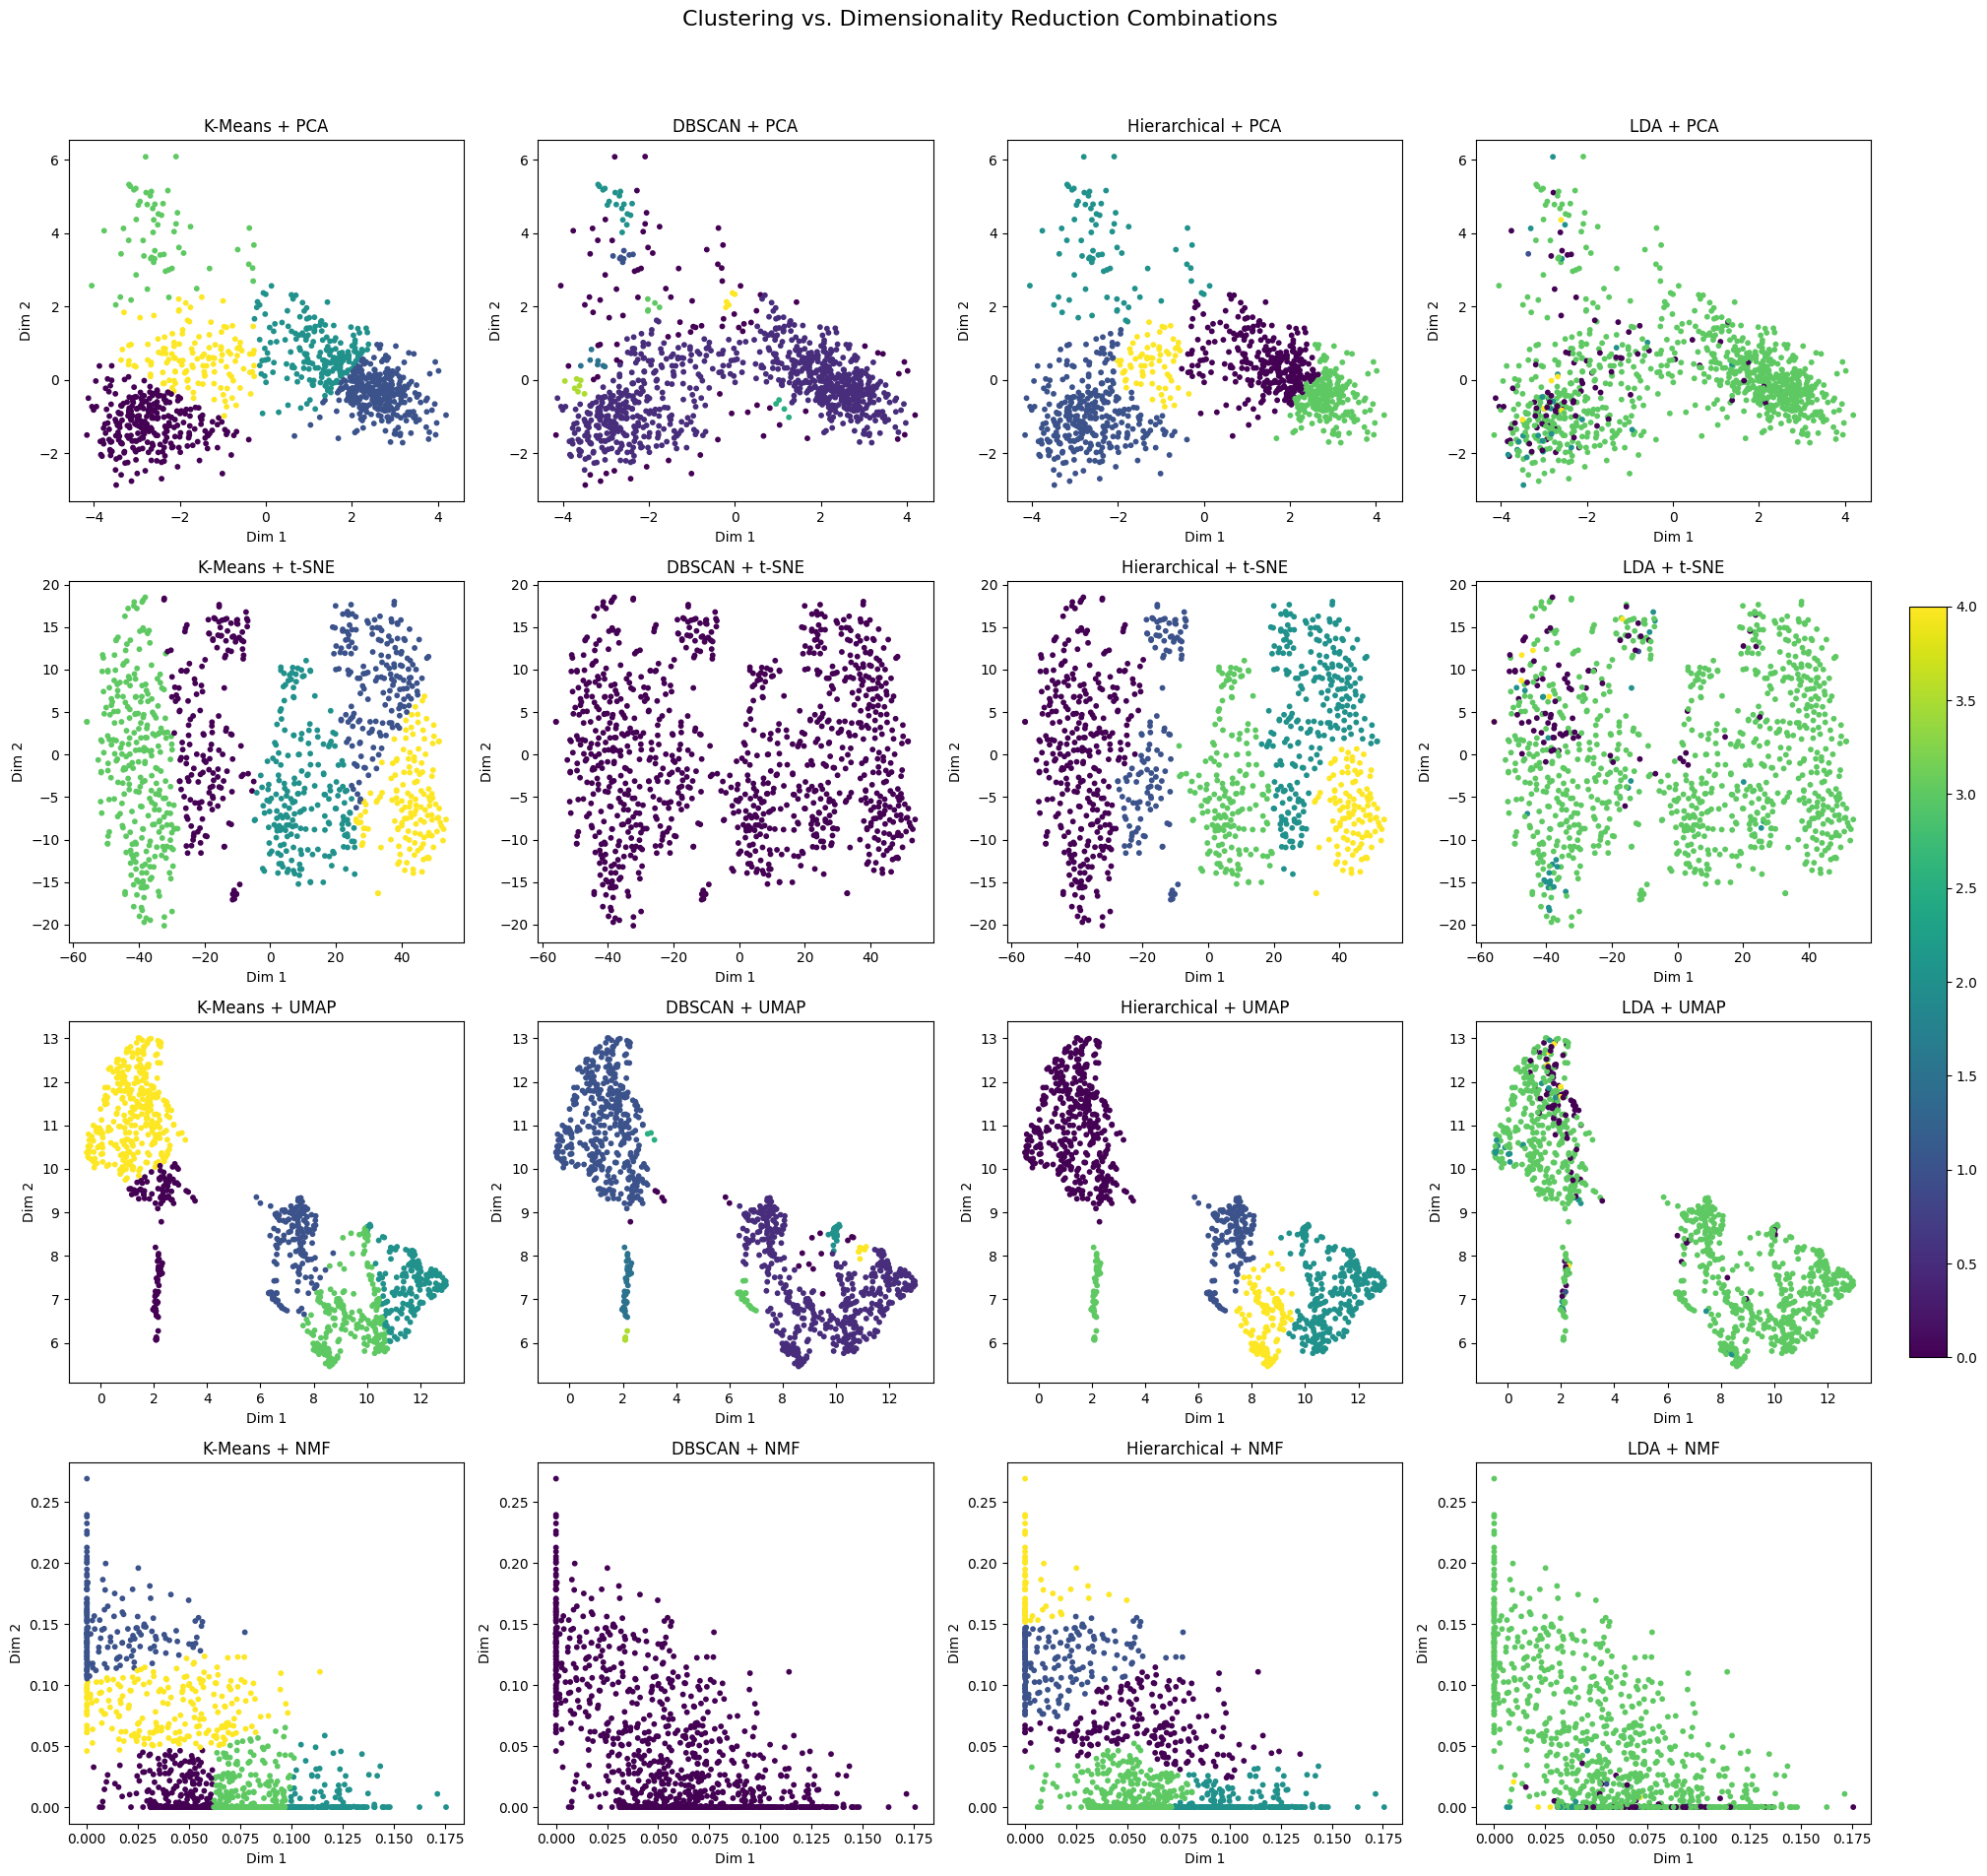

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

np.random.seed(42)
num_clusters = 5
bioBART_embeddings = embedding
tfidf_matrix = tfidf_matrix

# Define dimensionality reduction methods
dim_reduction_methods = {
    "PCA": PCA(n_components=2),
    "t-SNE": TSNE(n_components=2, random_state=42),
    "UMAP": UMAP(n_components=2, random_state=42),
    "NMF": NMF(n_components=2, random_state=42)
}

# Define clustering algorithms
clustering_methods = {
    "K-Means": KMeans(n_clusters=num_clusters, random_state=42),
    "DBSCAN": DBSCAN(eps=0.3, min_samples=5),
    "Hierarchical": AgglomerativeClustering(n_clusters=num_clusters),
    "LDA": LatentDirichletAllocation(n_components=num_clusters, random_state=42)
}

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("Clustering vs. Dimensionality Reduction Combinations", fontsize=16)

for i, (dim_name, dim_reducer) in enumerate(dim_reduction_methods.items()):
    # Choose the appropriate data based on the dimensionality reduction method
    if dim_name == "NMF" or dim_name == "LDA":
        matrix = tfidf_matrix  # Use TF-IDF for non-negative constraints
    else:
        matrix = bioBART_embeddings  # Use original embeddings

    reduced_data = dim_reducer.fit_transform(matrix)

    for j, (cluster_name, cluster_model) in enumerate(clustering_methods.items()):
        if cluster_name == "LDA":
            cluster_labels = cluster_model.fit_transform(tfidf_matrix).argmax(axis=1)
        else:
            cluster_labels = cluster_model.fit_predict(reduced_data)
        
        ax = axes[i, j]
        scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=10)
        ax.set_title(f"{cluster_name} + {dim_name}")
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
plt.show()
